# Introduction

According to the World Health Organization (WHO), stroke is the second leading cause of death globally, responsible for approximately 11% of total deaths.
Modern medicine is advancing and evolving rapidly, with a key objective being the ability to diagnose diseases using machine learning without the need for human intervention. Even 
today, there are quite a few tools that help doctors make accurate diagnoses based on symptoms and other characteristics.

Our chosen dataset can be used to predict whether a patient is likely to experience a stroke based on input parameters such as gender, age, underlying health conditions, and smoking status.
Our primary goal is to create a model that predicts the probability of a stroke during an individual’s lifetime, potentially enabling early intervention and preventive measures.

# Research Questions

1. Which combinations of health-related factors (e.g., hypertension, heart disease, BMI) show the strongest interaction in increasing the likelihood of a stroke?

2. Which demographic factors (e.g., age, gender, marital status, work type) have the strongest combined influence on stroke risk?

3. Are demographic factors or health-related factors more critical for accurately predicting stroke risk?

## Import the Required Modules

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib import colors
import seaborn as sns
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE 
from collections import Counter
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, cross_validate, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from scipy import stats
from sklearn.metrics import make_scorer, f1_score, confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
import shap

ImportError: Numba needs NumPy 2.0 or less. Got NumPy 2.1.

# Data Understanding

In [2]:
stroke_data = pd.read_csv('../input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv')

In [3]:
rows, cols = stroke_data.shape
print("There are %d Records and %d Features in the Stroke Prediction Dataset." % (rows, cols))

There are 5110 Records and 12 Features in the Stroke Prediction Dataset.


In [4]:
stroke_data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


**We can notice two important things:**
* The Dataset consists of a number of categorical features, we will need to handle it later
* We have NaN value in the *bmi* feature, we will check if there are more places that have missing values

## Searching for Missing Values

In [5]:
stroke_data.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

*bmi* feature has NaN missing values, we need to decide how to handle it...

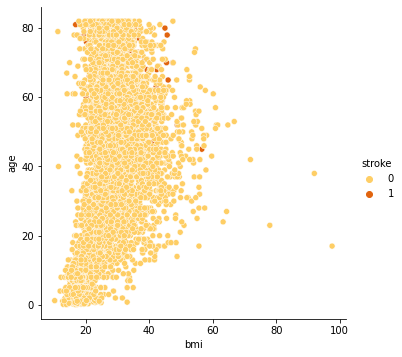

In [6]:
bmi_pairplot = sns.pairplot(data=stroke_data, y_vars='age', x_vars='bmi', hue='stroke',
                                    height=5, palette=sns.color_palette("YlOrBr", 2))

* Older people experienced more cases of stroke
* We can see that all the people has *bmi* in range of around 0-60 no matter how old they are.
* There are cases where people had stroke with high and low *bmi*. 

Because most of the *bmi* values are around the same values, we can replace the missing values by taking the mean/Median of the other values.

**We will do it in the next step - Data Preparation.**

Let's check that the other columns do not contain missing values:

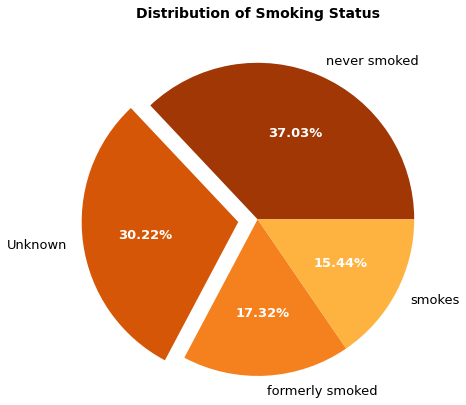

In [7]:
smoking_status = stroke_data['smoking_status'].value_counts()

fig, ax = plt.subplots(figsize =(8, 6))
_, _, autotexts = ax.pie(x=smoking_status, labels=smoking_status.index, autopct="%.2f%%", radius=1.2,
                         colors=sns.color_palette("YlOrBr_r"), explode=[0,0.15,0,0], textprops=dict(fontsize=13))

ax.set_title('Distribution of Smoking Status', y=1.1, weight='bold', fontsize=14)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_weight('bold')

More than 30% of our data has no smoking status, what should we do?

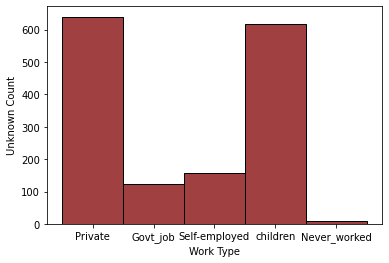

In [8]:
work_type_hist = sns.histplot(data=stroke_data[stroke_data.smoking_status == 'Unknown'], color='maroon', x="work_type")
work_type_hist.set(xlabel='Work Type', ylabel='Unknown Count')
plt.show()

* Most of the Unknown smoking status records are children or private.

Since most of the Unknown smoking status records are children, we could transfer all the Unknown records to never smoked category. This is beacuse we can assume that children not smoke. **But**, more than half of the other unknown records are not children, and we can not assume that they do not smoke too.

**TODO: decide what method is better - Drop or build anther model (?)**

To fix that, we can drop the other unknown smoking status.

In order to fill the unknown values properly, we can use a machine learning algorithem to predict the smoking status for each unknown value. Of course this method will not complete the data perfectly, but it can get relatively good results.

**We also will do it in the next step - Data Preparation.**

## Imbalance Data

Let's check if our data is balanced. There is a big chance that we have more records in which people have not experienced stroke than yes.

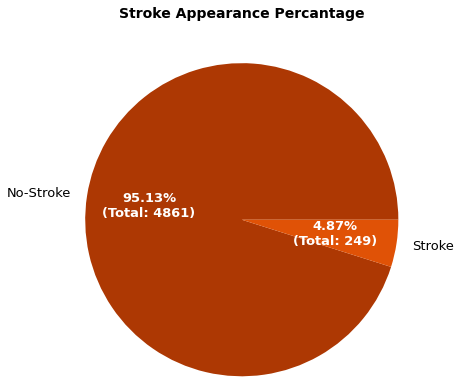

In [9]:
stroke_counts = stroke_data['stroke'].value_counts()

fig, ax = plt.subplots(figsize =(8, 6))
_, _, autotexts = ax.pie(x=stroke_counts, labels=['No-Stroke', 'Stroke'], radius=1.2,
                         autopct=lambda p: '{:.2f}%\n(Total: {:.0f})'.format(p,(p/100)*len(stroke_data)),
                         colors=sns.color_palette("Oranges_r"), textprops=dict(fontsize=13))

ax.set_title('Stroke Appearance Percantage', y=1.1, weight='bold', fontsize=14)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_weight('bold')

**We can see that our data is imbalance.** More than 95% of our data did not experience a stroke at all.

We will have to handle it in the next steps...

## Exploring Other Features

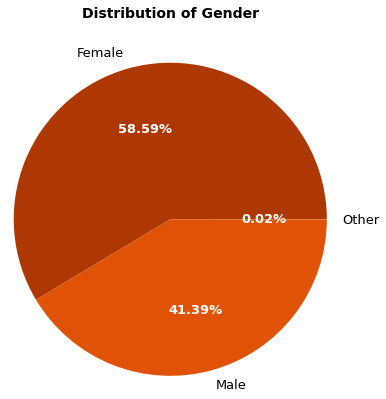

In [10]:
gender_counts = stroke_data['gender'].value_counts()

fig, ax = plt.subplots(figsize =(8, 6))
_, _, autotexts = ax.pie(x=gender_counts, labels=gender_counts.index, autopct="%.2f%%", radius=1.2,
                         colors=sns.color_palette("Oranges_r"), textprops=dict(fontsize=13))

ax.set_title('Distribution of Gender', y=1.1, weight='bold', fontsize=14)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_weight('bold')

**We can notice two important things:**
* A very small percentage of our records contains people who do not define themselves as Male or Female - we will drop the *other* records from our dataset to avoid bais.
* There are more Female records than Male records in our dataset

In [11]:
age_groups = pd.cut(x=stroke_data['age'], bins=[0,8,18,28,40,60,float('inf')], labels=["0-8","8-18","18-28","28-40","40-60","60+"])
age_counts = age_groups.value_counts().sort_index()

age_indexes = age_counts.index.values
age_values = age_counts.values

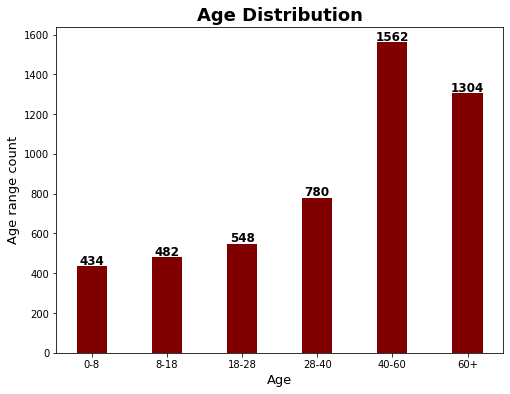

In [12]:
plt.figure(figsize = (8, 6))
 
# creating the bar plot
age_bar = plt.bar(age_indexes, age_values, color ='maroon', width = 0.4)
for i, rectangle in enumerate(age_bar):
    height = rectangle.get_height()
    plt.text(rectangle.get_x() + rectangle.get_width()/2, height+10,
             age_values[i], horizontalalignment='center', weight='bold', fontsize=12)
 
plt.xlabel("Age", fontsize=13)
plt.ylabel("Age range count", fontsize=13)
plt.title("Age Distribution", weight='bold', fontsize=18)
plt.show()

**We can notice:**
* Most of the population in our dataset are relatively old people, around the age of 40+

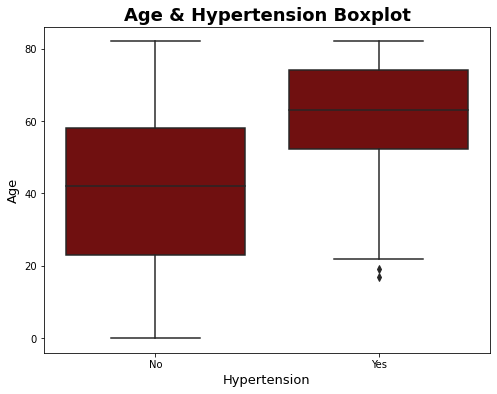

In [13]:
plt.figure(figsize=(8,6))

hyp_boxplot = sns.boxplot(data=stroke_data, x='hypertension', y='age', color='maroon')
hyp_boxplot.set_xticklabels(['No','Yes'])

plt.xlabel("Hypertension", fontsize=13)
plt.ylabel("Age", fontsize=13)
plt.title("Age & Hypertension Boxplot", weight='bold', fontsize=18)
plt.show()

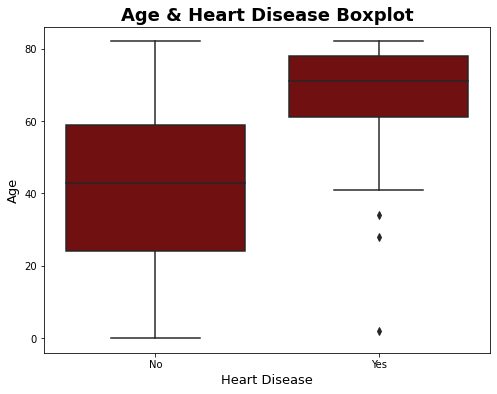

In [14]:
plt.figure(figsize=(8,6))

heart_boxplot = sns.boxplot(data=stroke_data, x='heart_disease', y='age', color='maroon')
heart_boxplot.set_xticklabels(['No','Yes'])

plt.xlabel("Heart Disease", fontsize=13)
plt.ylabel("Age", fontsize=13)
plt.title("Age & Heart Disease Boxplot", weight='bold', fontsize=18)
plt.show()

**We can notice:**
* The more you getting older, the chance of having hypertension or heart disease is higher

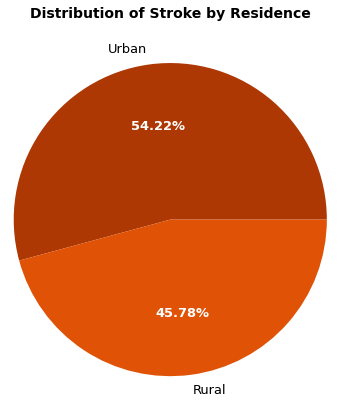

In [15]:
stroke_residence = stroke_data[stroke_data.stroke == 1]['Residence_type'].value_counts()

fig, ax = plt.subplots(figsize =(8, 6))
_, _, autotexts = ax.pie(x=stroke_residence, labels=stroke_residence.index, 
                         autopct="%.2f%%", radius=1.2, colors=sns.color_palette("Oranges_r"), textprops=dict(fontsize=13))

ax.set_title('Distribution of Stroke by Residence', y=1.1, weight='bold', fontsize=14)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_weight('bold')

**We can notice:**
* Stroke occurs in urban and also in rural almost at the same probability - this means that we maybe we not want want to include this feature in our model since it seems less affecting the chance of stroke.

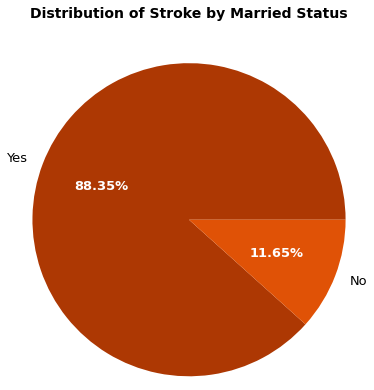

In [16]:
stroke_residence = stroke_data[stroke_data.stroke == 1]['ever_married'].value_counts()

fig, ax = plt.subplots(figsize =(8, 6))
_, _, autotexts = ax.pie(x=stroke_residence, labels=stroke_residence.index, 
                         autopct="%.2f%%", radius=1.2, colors=sns.color_palette("Oranges_r"), textprops=dict(fontsize=13))

ax.set_title('Distribution of Stroke by Married Status', y=1.1, weight='bold', fontsize=14)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_weight('bold')

**We can notice:**
* There is a relation between ever_married and stroke - most people who experince stroke were married.

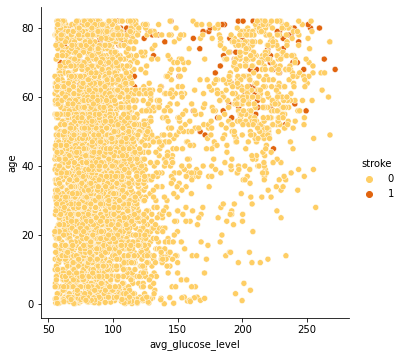

In [17]:
glucose_pairplot = sns.pairplot(data=stroke_data, y_vars='age', x_vars='avg_glucose_level', hue='stroke',
             height=5, palette=sns.color_palette("YlOrBr", 2))

**We can notice:**
* avg_glucose_level is effecting stroke in some way - most of the stroke cases occurred to people who have high avg_glucose_level.

# Data Preparation

**We need to preform the following things:**
* Convert categorial features to numeric
* Handling missing values - the NaN values in the *bmi* feature & 'Unknown' *smoking status*
* Droping outliers - *other* value in the *gender* feature 
* Select our main features
* Solve the non-balanced data problem
* Split to train & test

Let's start preparing our data step by step:

## Convert Categorial Features to Numeric

In [18]:
categorial_features = ['ever_married', 'work_type', 'Residence_type']

le = preprocessing.LabelEncoder()
for feature in categorial_features:
    stroke_data[feature] = le.fit_transform(stroke_data[feature])
    
stroke_data['gender'].replace(['Female', 'Male', 'Other'], [0, 1, 2], inplace=True)
stroke_data['smoking_status'].replace(['never smoked', 'smokes', 'formerly smoked', 'Unknown'], [0, 1, 2, 3], inplace=True)

stroke_data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,1,67.0,0,1,1,2,1,228.69,36.6,2,1
1,51676,0,61.0,0,0,1,3,0,202.21,NaN,0,1
2,31112,1,80.0,0,1,1,2,0,105.92,32.5,0,1
3,60182,0,49.0,0,0,1,2,1,171.23,34.4,1,1
4,1665,0,79.0,1,0,1,3,0,174.12,24.0,0,1


## Handling Missing Values

Replacing the NaN missing values in the *bmi* feature by taking the mean/Median of the other values:

In [19]:
# Replace using median 
bmi_median = stroke_data['bmi'].median()
stroke_data['bmi'].fillna(bmi_median, inplace=True)
stroke_data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,1,67.0,0,1,1,2,1,228.69,36.6,2,1
1,51676,0,61.0,0,0,1,3,0,202.21,28.1,0,1
2,31112,1,80.0,0,1,1,2,0,105.92,32.5,0,1
3,60182,0,49.0,0,0,1,2,1,171.23,34.4,1,1
4,1665,0,79.0,1,0,1,3,0,174.12,24.0,0,1


**TODO: just drop (?)**

Predicting the 'Unkonwn' missing values in the *smoking_status* column using Logistic Regression:
1. We will split our data to train and test. **Training set** - all the records that do not have missing values in the *smoking_status* column. **Test set** - all the records that do have missing values in the *smoking_status* column.
1. Create the Logistic Regression and train it.
1. Use the trained model to complete the missing values.

In [20]:
train = stroke_data[stroke_data.smoking_status != 3]
test = stroke_data[stroke_data.smoking_status == 3]

y_train = train['smoking_status']
X_train = train.drop(['id', 'smoking_status', 'Residence_type'],axis='columns')

X_test = test.drop(['id', 'smoking_status', 'Residence_type'],axis='columns')

In [21]:
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [22]:
smoking_status_preds = model.predict(X_test)
stroke_data.loc[stroke_data.smoking_status == 3, "smoking_status"] = smoking_status_preds
stroke_data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,1,67.0,0,1,1,2,1,228.69,36.6,2,1
1,51676,0,61.0,0,0,1,3,0,202.21,28.1,0,1
2,31112,1,80.0,0,1,1,2,0,105.92,32.5,0,1
3,60182,0,49.0,0,0,1,2,1,171.23,34.4,1,1
4,1665,0,79.0,1,0,1,3,0,174.12,24.0,0,1


## Droping Outliers

To avoid bias, we will remove all records with *other* gender value. There are very few records like that and we will not want them to affect badly on our model.

In [23]:
stroke_data[stroke_data.gender == 2]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,56156,2,26.0,0,0,0,2,0,143.33,22.4,2,0


In [24]:
stroke_data = stroke_data[stroke_data.gender != 2]
stroke_data[stroke_data.gender == 2]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke


The outliers in *bmi* feature will be remove in the next section since we will drop the entire feature.

## Select Main Features

Let's look on the features heatmap correlation before we decide on which features we give up:

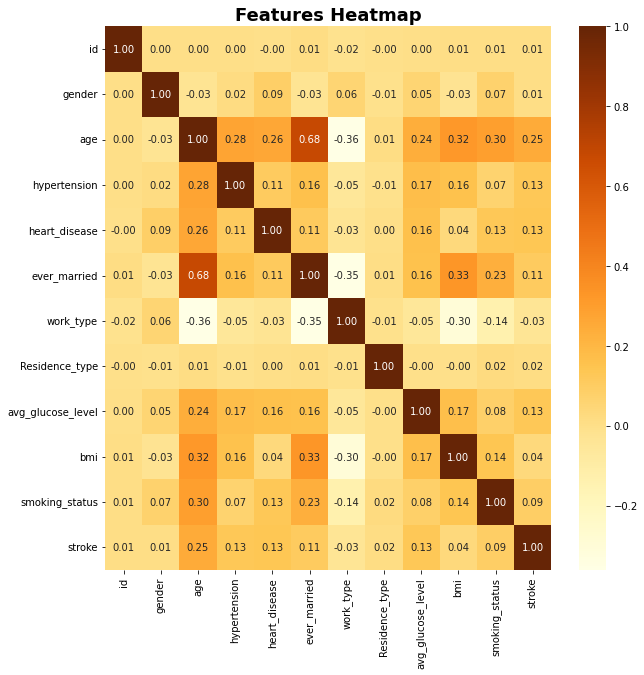

In [25]:
plt.figure(figsize=(10,10))

sns.heatmap(stroke_data.corr(), annot=True, fmt='.2f', cmap=sns.color_palette("YlOrBr", as_cmap=True))

plt.title("Features Heatmap", weight='bold', fontsize=18)
plt.show()

**We will drop the following features** - [*id, Residence_type, bmi*]

1. *id* - Of course not affecting the decision if a person has stroke or not
1. *Residence_type* - we saw earler in the 'Distribution of Stroke by Residence' diagram that stroke occurs in urban and also in rural almost at the same probability. In addition, we can see that correlation between this feature and stroke is very low (-0.02). All of these lead us to the decision that this feature will not help us determine whether person will experience stroke.
1. *bmi* - all people has *bmi* in range of around 0-60. There were cases where people had stroke with high and low *bmi*. It's correlation to stroke feature is also very low (0.04) and we know that there were missing values in this column.

In [26]:
# drop the values
stroke_data = stroke_data.drop(['id', 'Residence_type', 'bmi'], axis='columns')
stroke_data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,smoking_status,stroke
0,1,67.0,0,1,1,2,228.69,2,1
1,0,61.0,0,0,1,3,202.21,0,1
2,1,80.0,0,1,1,2,105.92,0,1
3,0,49.0,0,0,1,2,171.23,1,1
4,0,79.0,1,0,1,3,174.12,0,1


removing the target feature:

In [27]:
target = stroke_data['stroke']
stroke_data = stroke_data.drop('stroke',axis='columns')
stroke_data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,smoking_status
0,1,67.0,0,1,1,2,228.69,2
1,0,61.0,0,0,1,3,202.21,0
2,1,80.0,0,1,1,2,105.92,0
3,0,49.0,0,0,1,2,171.23,1
4,0,79.0,1,0,1,3,174.12,0


## Split to Train & Test

In [29]:
# split our data to train and test groups
X_train, X_test, y_train, y_test = train_test_split(stroke_data, target, test_size=0.4, random_state=42)

## Data Balancing

In order to fix this problem, we have to generate more samples of stroke records. To do so, we will use SMOTE. SMOTE should only be applied to the training set to prevent data leakage.

In [ ]:
# the data is not balance
print(Counter(target))
# balance the data - generate more stroke sampels
sm = SMOTE()
stroke_data, target = sm.fit_resample(stroke_data, target)
# now the data is balance
print(Counter(target))

# Modeling

We will examine several different models:

In [30]:
models = [KNeighborsClassifier(), DecisionTreeClassifier(), RandomForestClassifier(), AdaBoostClassifier(),
          GradientBoostingClassifier(), XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='mlogloss')]
models_names = ['KNeighborsClassifier', 'DecisionTreeClassifier', 'RandomForestClassifier',
                'AdaBoostClassifier', 'GradientBoostingClassifier', 'XGBClassifier']

In [31]:
def model_score(model, X, Y):
    accuracy_value = cross_val_score(model, X, Y, scoring='accuracy', cv=5).mean()
    recall_value = cross_val_score(model, X, Y, scoring='recall', cv=5).mean()
    precision_value = cross_val_score(model, X, Y, scoring='precision', cv=5).mean()
    f1_value = cross_val_score(model, X, Y, scoring='f1', cv=5).mean()
    return accuracy_value, recall_value, precision_value, f1_value

In [32]:
accuracy,recall,precision,f1 = [],[],[],[]

for model in models:
    accuracy_value, recall_value, precision_value, f1_value = model_score(model, X_train, y_train)
    accuracy.append(accuracy_value)
    recall.append(recall_value)    
    precision.append(precision_value)    
    f1.append(f1_value)    

In [33]:
models_performence = pd.DataFrame({'Model': models_names, 'Accuracy': accuracy, 'Recall': recall, 'Precision': precision, 'F1': f1})
models_performence.style.background_gradient(cmap=sns.color_palette("YlOrBr", as_cmap=True), high=1)

,Model,Accuracy,Recall,Precision,F1
0,KNeighborsClassifier,0.858196,0.950000,0.804266,0.871036
1,DecisionTreeClassifier,0.899520,0.913605,0.889818,0.903216
2,RandomForestClassifier,0.921125,0.942177,0.900547,0.919836
3,AdaBoostClassifier,0.833678,0.867347,0.815164,0.840293
4,GradientBoostingClassifier,0.860938,0.890136,0.843244,0.865847
5,XGBClassifier,0.944444,0.951020,0.939580,0.945230


The model with the best performance is **XGBClassifier**, we will select it.

Now let's try improve model preformence by choosing a set of optimal hyperparameters for a learning algorithm.

## Hyperparameter Tuning

Let's find the best hyperparameters for the XGBClassifier model.

We will use the Grid Search technique for finding the best hyperparameters values from finite set we defined below.

In [34]:
xgb = XGBClassifier(objective = 'binary:logistic', use_label_encoder=False, eval_metric='mlogloss')
hyperparameter_values = {'n_estimators': [100, 200, 300],
                          'learning_rate': [0.1, 0.2, 0.3],
                          'max_depth': [3, 6, 9],
                          'colsample_bytree': [0.5, 0.75, 1]
                         }

kfold_5 = KFold(n_splits=5, shuffle=True)
clf = GridSearchCV(xgb, param_grid=hyperparameter_values, cv=kfold_5, scoring=make_scorer(f1_score))

# Fit the grid search to the data
clf.fit(X_train, y_train)
xgb_best_params = clf.best_params_
xgb_best_params

{'colsample_bytree': 1,
 'learning_rate': 0.3,
 'max_depth': 6,
 'n_estimators': 300}

We will build the XGBClassifier model with the best hyperparameters and compare it to the previous results:

In [35]:
xgb = XGBClassifier(objective = 'binary:logistic', use_label_encoder=False, eval_metric='mlogloss', **xgb_best_params)

accuracy_value, recall_value, precision_value, f1_value = model_score(xgb, X_train, y_train)
best_scoring = [accuracy_value, recall_value, precision_value, f1_value]
prev_scoring = [accuracy[5], recall[5],  precision[5], f1[5]]
metrics = ['Accuracy', 'Recall', 'Precision', 'F1']

models_performence = pd.DataFrame({'Metrics': metrics, 'Prev XGB': prev_scoring, 'Best XGB': best_scoring})

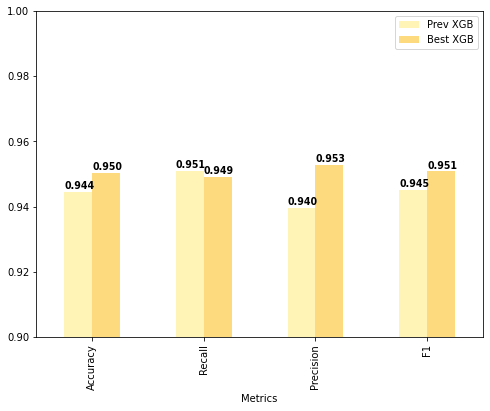

In [36]:
ax = models_performence.plot(kind="bar", x='Metrics', y=['Prev XGB', 'Best XGB'],
                            color=sns.color_palette("YlOrBr"), figsize = (8, 6))
ax.set(ylim=[0.9, 1])
for p in ax.patches:
    b = p.get_bbox()
    ax.annotate("{:.3f}".format(b.y1 + b.y0), (b.x0, b.y1+0.001), fontsize=9.5, weight='bold')

As we can see, we successfully improved all of the evaluation metrix whom we examine our model.

Our final model will be Random Forest with this hyperparameters values. Let's build and train the model:

In [37]:
model = XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='mlogloss', **xgb_best_params)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.3, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

# Evaluation

We will evaluate our model using several methods:

## Confusion Matrix

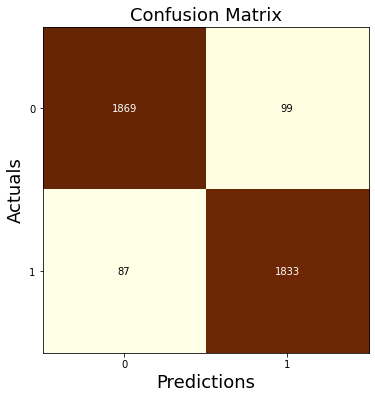

False Positive Rate: 0.050
False Negative Rate: 0.045


In [38]:
pred = model.predict(X_test)
conf_matrix = confusion_matrix(y_test, pred)

# Print the confusion matrix using Matplotlib
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=sns.color_palette("YlOrBr", as_cmap=True))
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

print("False Positive Rate: {:.3f}".format(conf_matrix[0][1] / (conf_matrix[0][0] + conf_matrix[0][1])))
print("False Negative Rate: {:.3f}".format(conf_matrix[1][0] / (conf_matrix[1][0] + conf_matrix[1][1])))

## Classification Report

In [39]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1968
           1       0.95      0.95      0.95      1920

    accuracy                           0.95      3888
   macro avg       0.95      0.95      0.95      3888
weighted avg       0.95      0.95      0.95      3888



## 5-Cross Validation

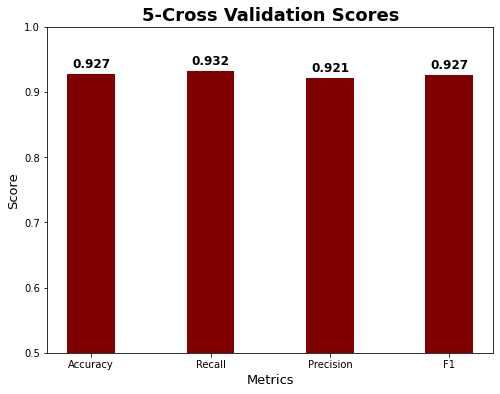

In [40]:
accuracy_value, recall_value, precision_value, f1_value = model_score(model, X_test, y_test)
scoring_values = [accuracy_value, recall_value, precision_value, f1_value]

plt.figure(figsize = (8, 6))
 
# creating the bar plot
test_scoring_bar = plt.bar(metrics, scoring_values, color ='maroon', width = 0.4)
ax = plt.gca()
ax.set_ylim([0.5, 1])
for i, rectangle in enumerate(test_scoring_bar):
    height = rectangle.get_height()
    plt.text(rectangle.get_x() + rectangle.get_width()/2, height+0.01,
             "{:.3f}".format(scoring_values[i]), horizontalalignment='center', weight='bold', fontsize=12)
 
plt.xlabel("Metrics", fontsize=13)
plt.ylabel("Score", fontsize=13)
plt.title("5-Cross Validation Scores", weight='bold', fontsize=18)
plt.show()

As we can see, all of our evaluation methods return very good results.

# Feature Importance

Finally, we want to examine what were the main features that influenced the model to decide whether person will experience stroke or not. To do so, we will use SHAP tool as we seen in class:

In [41]:
# load JS visualization code to notebook
shap.initjs()

In [42]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


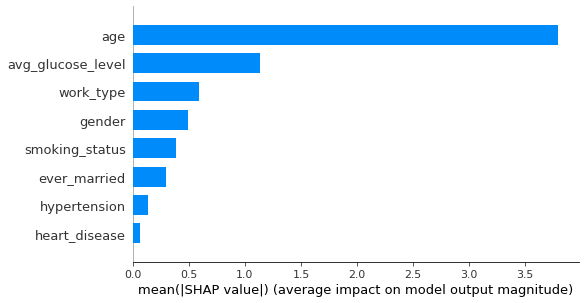

In [43]:
shap.summary_plot(shap_values, features=X_test, feature_names=X_test.columns, plot_type="bar")

**We can see some intresting results:**
* *Age* is the most affecting feature, as expected. Many medical studies show that aging significantly increases the chances of stroke.
* *avg_glucose_level* is the second most affecting feature. We indeed saw in the Data Understending section that there is some connection between it and stroke.
* *hypertension* & *heart_disease* are the less affecting features. And indeed, quick internet search did not find official studies that approve the above mentioned connection.

# Answers - Reserch Questions

1.
2.
3.